#EECS 442 PS6: Image Synthesis

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Javier] [Salazar Cavazos], [javiersc]

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: adam_01101100.ipynb.



__Note__: There are cells in this notebook that are specific to 504 students, if you are a 442 student please delete/comment them out while submitting the notebook/the pdf file.


# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [1]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Using the GPU!


# Problem 6.1 pix2pix
You will build pix2pix for image translation. 

In this question, you will need to:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the results during training
4. Plot the loss of generator/discriminator v.s. iteration
5. Design your own shoes (optional)

## Step 0: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs.

There's nothing you need to implement for this part.

In [2]:
# Download the mini-edges2shoes dataset
!rm -r mini-edges2shoes.zip
!rm -r mini-edges2shoes
!wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
!unzip -q mini-edges2shoes.zip

rm: cannot remove 'mini-edges2shoes.zip': No such file or directory
rm: cannot remove 'mini-edges2shoes': No such file or directory
--2022-10-16 16:21:59--  http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48660290 (46M) [application/zip]
Saving to: ‘mini-edges2shoes.zip’

mini-edges2shoes.zi 100%[===================>]  46.41M  11.2MB/s    in 4.2s    

2022-10-16 16:22:04 (11.0 MB/s) - ‘mini-edges2shoes.zip’ saved [48660290/48660290]



## Step 1: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. 

In [3]:
class Edges2Image(Dataset):
  def __init__(self, root_dir, split='train', transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """

    self.transform = transform
    ###########################################################################
    # TODO: get the the file path to all train/val images                     #
    # Hint: the function glob.glob is useful                                  #
    ###########################################################################

    self.files = glob.glob( '**/'+split+'/*.jpg', recursive=True)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.files[idx])
    img = np.asarray(img)
    if self.transform:
        img = self.transform(img)
    return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should ve named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = Edges2Image(root_dir="/",split="train",transform=transform)
te_dt = Edges2Image(root_dir="/",split="val",transform=transform)
train_loader= torch.utils.data.DataLoader(tr_dt, batch_size=4, shuffle=True)
test_loader= torch.utils.data.DataLoader(te_dt, batch_size=5, shuffle=False)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1000, number of testing images 100


250
20
torch.Size([5, 3, 256, 256])


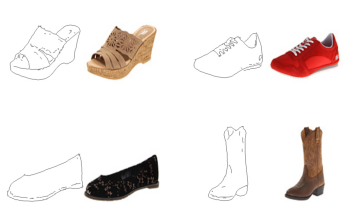

In [5]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  example = std * example + mean
  axes[i].imshow(example)
  axes[i].axis('off')
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

We have included a toy example of a U-net architecture below.
Encoder: C64-C128-C256
Decoder: C128-C64-C3

In [ ]:
# (Not a part of your solution) Toy example of an U-net architecture
class toy_unet(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    # encoder
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    # decoder
    self.deconv1 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1)
    self.deconv2 = nn.ConvTranspose2d(64 * 2 * 2, 64, 4, 2, 1)
    self.deconv3 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)

  # forward method
  def forward(self, input):
    # pass through encoder
    e1 = self.conv1(input)
    e2 = self.conv2(F.relu(e1))
    e3 = self.conv3(F.relu(e2))
    # pass through decoder
    d1 = self.deconv1(F.relu(e3))
    d1 = torch.cat([d1, e2], 1) # Concatenation
    d2 = self.deconv2(F.relu(d1))
    d2 = torch.cat([d2, e1], 1) # Concatenation
    d3 = self.deconv3(F.relu(d2))
    return d3

In [6]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()
    # delete end

In [7]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    ###########################################################################
    # TODO: Build your Unet generator encoder with the layer sizes            #
    # You can also check the size with the model summary below                #
    ###########################################################################
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.batch3 = nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv4 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    self.batch5 = nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv6 = nn.Conv2d(256, 512, 4, 2, 1)
    self.batch7 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv8 = nn.Conv2d(512, 512, 4, 2, 1)
    self.batch9 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv10 = nn.Conv2d(512, 512, 4, 2, 1)
    self.batch11 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv12 = nn.Conv2d(512, 512, 4, 2, 1)
    self.batch13 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv14 = nn.Conv2d(512, 512, 4, 2, 1)
    
    self.erelu = nn.LeakyReLU(0.2, inplace=True)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    ###########################################################################
    # TODO: Build your Unet generator decoder with the layer sizes            #
    ###########################################################################

    self.upconv15 = nn.ConvTranspose2d(512,512,4,2,1)
    self.batch16 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv17 = nn.ConvTranspose2d(512*2,512,4,2,1)
    self.batch18 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv19 = nn.ConvTranspose2d(512*2,512,4,2,1)
    self.batch20 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv21 = nn.ConvTranspose2d(512*2,512,4,2,1)
    self.batch22 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv23 = nn.ConvTranspose2d(512*2,256,4,2,1)
    self.batch24 = nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv25 = nn.ConvTranspose2d(256*2,128,4,2,1)
    self.batch26 = nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv27 = nn.ConvTranspose2d(128*2,64,4,2,1)
    self.batch28 = nn.BatchNorm2d(64,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.upconv29= nn.ConvTranspose2d(64*2,3,4,2,1)

    self.drelu = nn.ReLU(inplace=True)
    self.tan = nn.Tanh()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of generator                           #
    ###########################################################################
    # encoding
    e1 = self.conv1(input)
    e2 = self.conv2(self.erelu(e1))
    e3 = self.batch3(e2)
    e4 = self.conv4(self.erelu(e3))
    e5 = self.batch5(e4)
    e6 = self.conv6(self.erelu(e5))
    e7 = self.batch7(e6)
    e8 = self.conv8(self.erelu(e7))
    e9 = self.batch9(e8)
    e10 = self.conv10(self.erelu(e9))
    e11 = self.batch11(e10)
    e12 = self.conv12(self.erelu(e11))
    e13 = self.batch13(e12)
    e14 = self.conv14(self.erelu(e13))

    # decoding
    # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs
    d15 = self.upconv15(self.drelu(e14))
    d16 = self.batch16(d15)
    d16 = torch.cat([d16, e13], 1)
    d17 = self.upconv17(self.drelu(d16))
    d18 = self.batch18(d17)
    d18 = torch.cat([d18, e11], 1)
    d19 = self.upconv19(self.drelu(d18))
    d20 = self.batch20(d19)
    d20 = torch.cat([d20, e9], 1)
    d21 = self.upconv21(self.drelu(d20))
    d22 = self.batch22(d21)
    d22 = torch.cat([d22, e7], 1)
    d23 = self.upconv23(self.drelu(d22))
    d24 = self.batch24(d23)
    d24 = torch.cat([d24, e5], 1)
    d25 = self.upconv25(self.drelu(d24))
    d26 = self.batch26(d25)
    d26 = torch.cat([d26, e3], 1)
    d27 = self.upconv27(self.drelu(d26))
    d28 = self.batch28(d27)
    d28 = torch.cat([d28, e1], 1)
    output = self.upconv29(self.drelu(d28))
    output = self.tan(output)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return output

class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()
    ###########################################################################
    # TODO: Build your CNN discriminator with the layer sizes                 #
    ###########################################################################

    self.conv1 = nn.Conv2d(3*2, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
    self.batch3 = nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv4 = nn.Conv2d(128, 256, 4, 2, 1)
    self.batch5 = nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv6 = nn.Conv2d(256, 512,4,1,1)
    self.batch7 = nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)
    self.conv8 = nn.Conv2d(512, 1, 4,1,1)
    self.erelu = nn.LeakyReLU(0.2, inplace=True)
    self.sigmoid = nn.Sigmoid()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of discriminator                       #
    ###########################################################################

    e1 = self.conv1(input)
    e2 = self.conv2(self.erelu(e1))
    e3 = self.batch3(e2)
    e4 = self.conv4(self.erelu(e3))
    e5 = self.batch5(e4)
    e6 = self.conv6(self.erelu(e5))
    e7 = self.batch7(e6)
    e8 = self.conv8(self.erelu(e7))
    x = self.sigmoid(e8)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return x

In [8]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [8]:
D

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (batch7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (erelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
)

In [9]:
G

generator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv10): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(512, 512, kernel_size=(4, 4), str

**Make sure your model architecturees summary from the above cell match with the given architecture below.**

### generator architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 512, 1, 1]       4,194,816
    ConvTranspose2d-15            [-1, 512, 2, 2]       4,194,816
        BatchNorm2d-16            [-1, 512, 2, 2]           1,024
    ConvTranspose2d-17            [-1, 512, 4, 4]       8,389,120
        BatchNorm2d-18            [-1, 512, 4, 4]           1,024
    ConvTranspose2d-19            [-1, 512, 8, 8]       8,389,120
        BatchNorm2d-20            [-1, 512, 8, 8]           1,024
    ConvTranspose2d-21          [-1, 512, 16, 16]       8,389,120
        BatchNorm2d-22          [-1, 512, 16, 16]           1,024
    ConvTranspose2d-23          [-1, 256, 32, 32]       4,194,560
        BatchNorm2d-24          [-1, 256, 32, 32]             512
    ConvTranspose2d-25          [-1, 128, 64, 64]       1,048,704
        BatchNorm2d-26          [-1, 128, 64, 64]             256
    ConvTranspose2d-27         [-1, 64, 128, 128]         262,208
        BatchNorm2d-28         [-1, 64, 128, 128]             128
    ConvTranspose2d-29          [-1, 3, 256, 256]           6,147
----------------------------------------------------------------
    Total params: 54,419,459
    Trainable params: 54,419,459
    Non-trainable params: 0
----------------------------------------------------------------


### discriminator architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 1, 30, 30]           8,193
----------------------------------------------------------------
    Total params: 2,769,601
    Trainable params: 2,769,601
    Non-trainable params: 0
----------------------------------------------------------------


## Step 3: Train

In this section, complete the function train. 
Then train two model: one with only L1 loss, the other with c=100.



In [9]:
# Helper function for showing result.
def process_image(img):
  return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))
  
  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
  '''
  Counts the number of trainable parameters in PyTorch.
  Args:
      model: PyTorch model.
  Returns:
      num_params: int, number of trainable parameters.
  '''
  num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
  return num_params

In [13]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
  hist_D_losses = []
  hist_G_losses = []
  hist_G_L1_losses = []
  ###########################################################################
  # TODO: Add Adam optimizer to generator and discriminator                 #
  # You will use lr=0.0002, beta=0.5, beta2=0.999                           #
  ###########################################################################
  G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
  D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  print('training start!')
  start_time = time.time()
  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_ in train_loader:

      y_ = x_[:, :, :, img_size:]
      x_ = x_[:, :, :, 0:img_size]
      
      x_, y_ = x_.cuda(), y_.cuda()
      ###########################################################################
      # TODO: Implement training code for the discriminator.                    #
      # Recall that the loss is the mean of the loss for real images and fake   #
      # images, and made by some calculations with zeros and ones               #
      # We have defined the BCE_loss, which you might would like to use         #
      ###########################################################################
      D.zero_grad()
      input_real = torch.cat([x_, y_], dim=1)
      input_fake = torch.cat([x_, G(x_)] , dim=1)
      output_fake = D(input_fake)
      output_real = D(input_real)
      loss_d_1 = BCE_loss(output_fake, torch.zeros(output_fake.size()).cuda())
      loss_d_2 = BCE_loss(output_real, torch.ones(output_real.size()).cuda())
      loss_D = (loss_d_1 + loss_d_2)*0.5
      loss_D.backward()
      D_optimizer.step()

      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################   

      # Train the generator
      G.zero_grad()

      G_result = G(x_)
      D_input = torch.cat([x_, G_result], 1)
      D_result = D(D_input).squeeze()

      if only_L1:
        G_train_loss = L1_loss(G_result, y_)
        hist_G_losses.append(L1_loss(G_result, y_).detach().item())
      else:
        G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
        hist_G_L1_losses.append(L1_loss(G_result, y_).detach().item())
        hist_G_losses.append(BCE_loss(D_result, torch.ones(D_result.size()).cuda()).detach().item())
      
      G_train_loss.backward()
      G_optimizer.step()
      loss_G = G_train_loss.detach().item()

      D_losses.append(loss_D)
      hist_D_losses.append(loss_D)
      G_losses.append(loss_G)
      num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
    if epoch == 0 or (epoch + 1) % 5 == 0:
      with torch.no_grad():
        show_result(G, fixed_x_, fixed_y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time

  return hist_D_losses, hist_G_losses, hist_G_L1_losses

In this part, train your model with c=100 with at least 20 epochs.

In [14]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (batch7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (erelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
)

training start!
Start training epoch 1
[1/20] - using time: 82.50 seconds
loss of discriminator D: 0.509
loss of generator G: 27.729


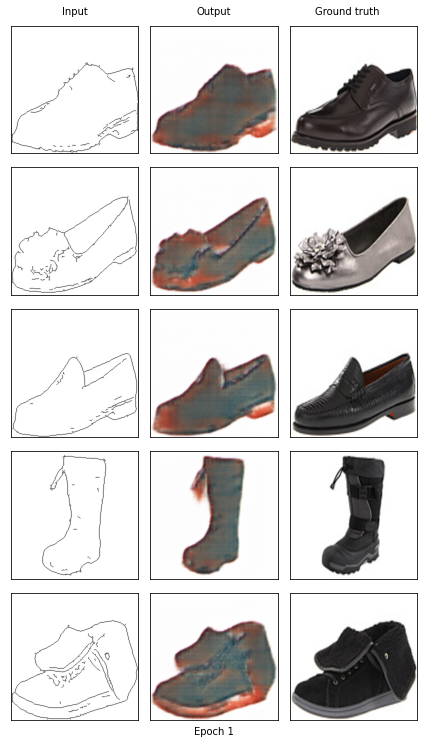

Start training epoch 2
[2/20] - using time: 81.92 seconds
loss of discriminator D: 0.449
loss of generator G: 20.498
Start training epoch 3
[3/20] - using time: 81.82 seconds
loss of discriminator D: 0.496
loss of generator G: 19.341
Start training epoch 4
[4/20] - using time: 81.70 seconds
loss of discriminator D: 0.511
loss of generator G: 18.404
Start training epoch 5
[5/20] - using time: 81.50 seconds
loss of discriminator D: 0.546
loss of generator G: 16.557


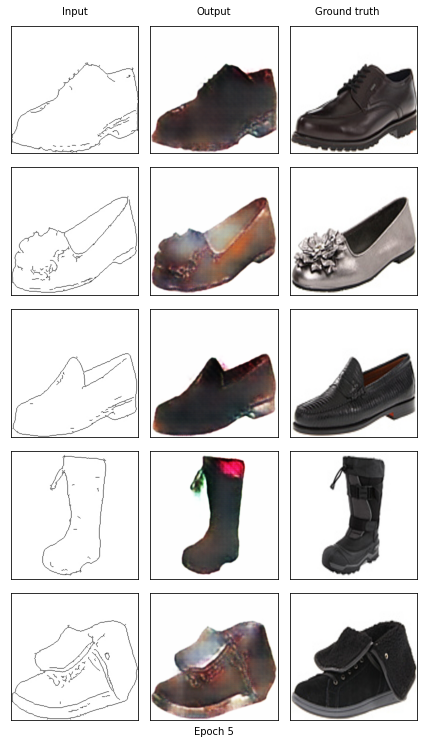

Start training epoch 6
[6/20] - using time: 82.12 seconds
loss of discriminator D: 0.528
loss of generator G: 15.664
Start training epoch 7
[7/20] - using time: 81.59 seconds
loss of discriminator D: 0.525
loss of generator G: 14.734
Start training epoch 8
[8/20] - using time: 81.76 seconds
loss of discriminator D: 0.552
loss of generator G: 13.893
Start training epoch 9
[9/20] - using time: 81.51 seconds
loss of discriminator D: 0.540
loss of generator G: 12.803
Start training epoch 10
[10/20] - using time: 81.53 seconds
loss of discriminator D: 0.554
loss of generator G: 12.065


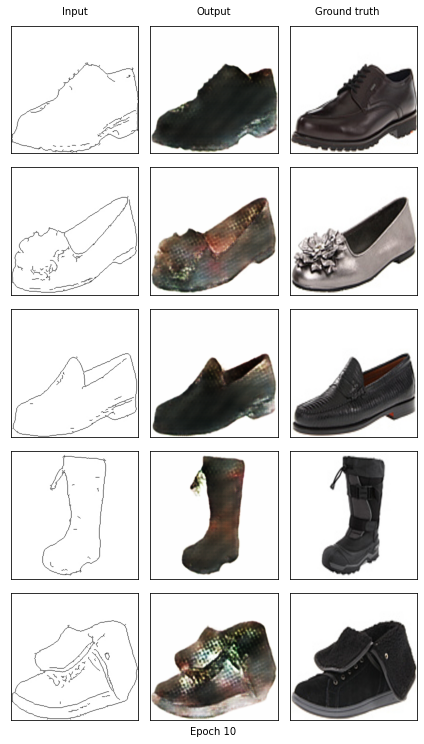

Start training epoch 11
[11/20] - using time: 81.70 seconds
loss of discriminator D: 0.560
loss of generator G: 11.457
Start training epoch 12
[12/20] - using time: 81.49 seconds
loss of discriminator D: 0.579
loss of generator G: 10.771
Start training epoch 13
[13/20] - using time: 81.59 seconds
loss of discriminator D: 0.577
loss of generator G: 10.234
Start training epoch 14
[14/20] - using time: 81.40 seconds
loss of discriminator D: 0.594
loss of generator G: 9.800
Start training epoch 15
[15/20] - using time: 81.51 seconds
loss of discriminator D: 0.580
loss of generator G: 9.367


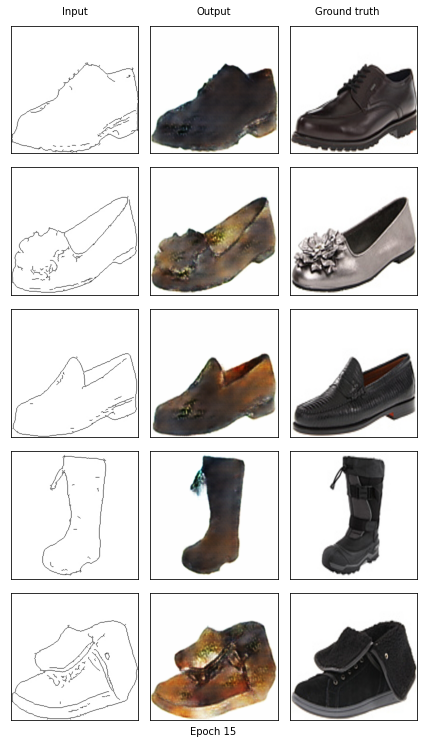

Start training epoch 16
[16/20] - using time: 81.40 seconds
loss of discriminator D: 0.583
loss of generator G: 8.984
Start training epoch 17
[17/20] - using time: 81.41 seconds
loss of discriminator D: 0.590
loss of generator G: 8.645
Start training epoch 18
[18/20] - using time: 81.33 seconds
loss of discriminator D: 0.588
loss of generator G: 8.472
Start training epoch 19
[19/20] - using time: 81.63 seconds
loss of discriminator D: 0.576
loss of generator G: 8.281
Start training epoch 20
[20/20] - using time: 81.45 seconds
loss of discriminator D: 0.585
loss of generator G: 8.229


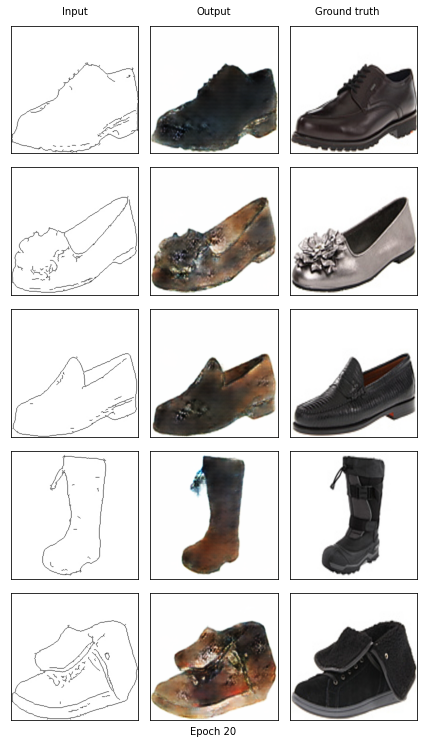

In [15]:
#training, you will be expecting 1-2 minutes per epoch.
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_BCE_losses, hist_G_100_L1_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [16]:
!mkdir models
torch.save(G_100.state_dict(), './models/G_100.pth')
torch.save(D_100.state_dict(), './models/D_100.pth')

In this part, train your model with only L1 loss with 10 epochs.

training start!
Start training epoch 1
[1/10] - using time: 75.37 seconds
loss of discriminator D: 0.292
loss of generator G: 0.257


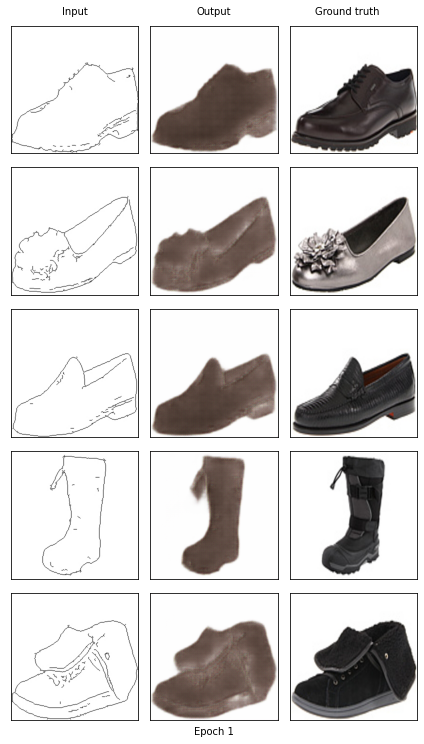

Start training epoch 2
[2/10] - using time: 74.94 seconds
loss of discriminator D: 0.058
loss of generator G: 0.184
Start training epoch 3
[3/10] - using time: 74.82 seconds
loss of discriminator D: 0.109
loss of generator G: 0.173
Start training epoch 4
[4/10] - using time: 74.77 seconds
loss of discriminator D: 0.031
loss of generator G: 0.162
Start training epoch 5
[5/10] - using time: 74.73 seconds
loss of discriminator D: 0.003
loss of generator G: 0.150


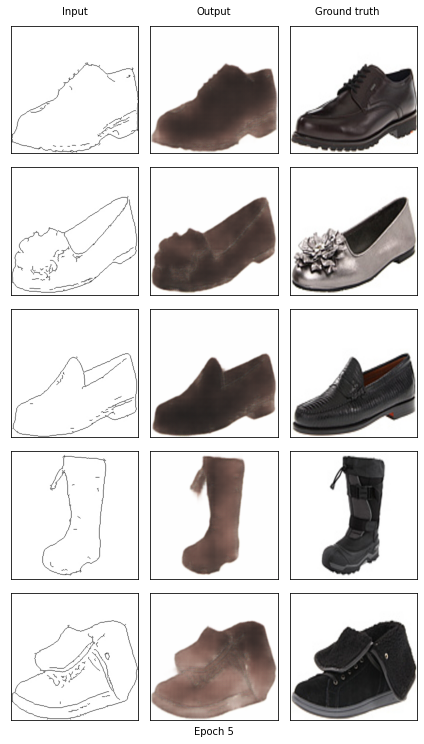

Start training epoch 6
[6/10] - using time: 74.64 seconds
loss of discriminator D: 0.086
loss of generator G: 0.138
Start training epoch 7
[7/10] - using time: 74.76 seconds
loss of discriminator D: 0.146
loss of generator G: 0.129
Start training epoch 8
[8/10] - using time: 74.45 seconds
loss of discriminator D: 0.035
loss of generator G: 0.121
Start training epoch 9
[9/10] - using time: 74.53 seconds
loss of discriminator D: 0.020
loss of generator G: 0.113
Start training epoch 10
[10/10] - using time: 74.29 seconds
loss of discriminator D: 0.025
loss of generator G: 0.107


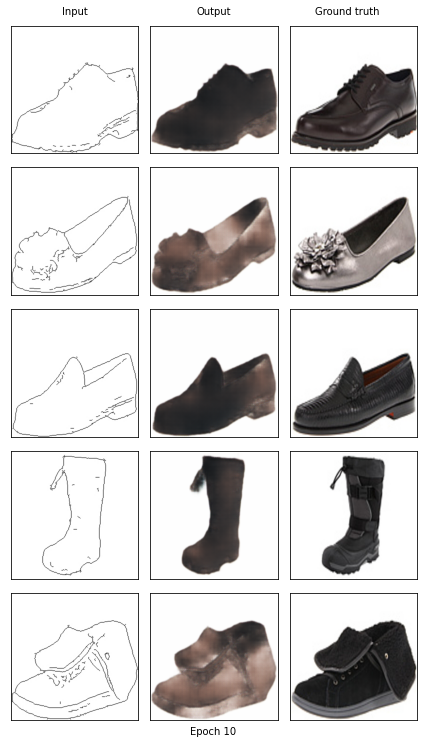

In [17]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

# training
hist_D_L1_losses, hist_G_L1_losses, _ = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

In [18]:
torch.save(G_L1.state_dict(), './models/G_L1.pth')
torch.save(D_L1.state_dict(), './models/D_L1.pth')

The following cell saves the trained model parameters to your Google Drive so you could reuse those parameters later without retraining.

In [19]:
from google.colab import drive
drive.mount('/content/drive')
!cp "./models/" -r "/content/drive/My Drive/"

Mounted at /content/drive


### **TODO**: Please comment on the quality of generated images from L1+cGAN and L1 only:

***L1+cGAN is able to capture more texture and color versus L1 only. Overall, those pictures look better than using L1 only which produce blurry images but using the higher quality cGAN comes at a price since the cGAN appears to introduce more artifacts.  ***

## Step 4: Visualization



Please plot the generator BCE and L1 losses, as well as the discriminator loss. For this, please use c=100, and use 3 separate plots.

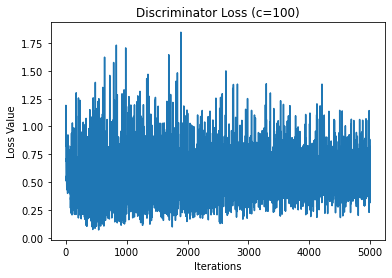

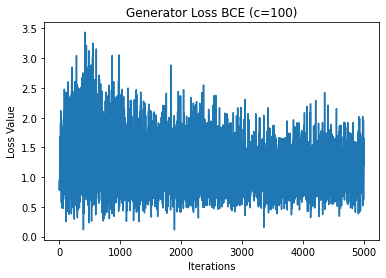

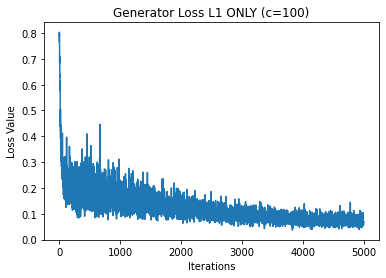

In [41]:
###########################################################################
# TODO: Plot the G/D loss history (y axis) vs. Iteration (x axis)         #
# You will have three plots, with hist_D_100_losses,                      #
# hist_G_100_BCE_losses, hist_G_100_L1_losses respectively.               #
# Hiint: Use plt.legend if you want visualize the annotation for your     #
# curve                                                                   #
###########################################################################

plt.plot(torch.stack(hist_D_100_losses).cpu().detach().numpy())
plt.title("Discriminator Loss (c=100)")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.show()


plt.plot(hist_G_100_BCE_losses)
plt.title("Generator Loss BCE (c=100)")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.show()


plt.plot(hist_G_100_L1_losses)
plt.title("Generator Loss L1 ONLY (c=100)")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.show()

###########################################################################
#                              END OF YOUR CODE                           #
########################################################################### 

In this section, plot the G/D loss history vs. Iteration of model with only L1 loss in 2 seperate plots.

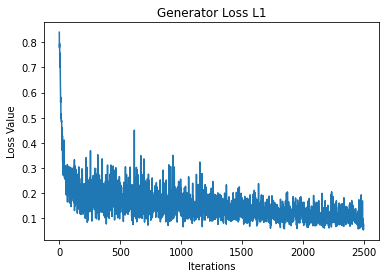

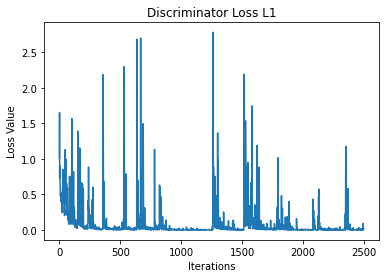

In [44]:
###########################################################################
# TODO: Plot the G/D loss history vs. Iteration in one plot               #
# You will have two plots, with hist_G_L1_losses and hist_D_L1_losses     #
# respectively                                                            #
###########################################################################

plt.plot(hist_G_L1_losses)
plt.title("Generator Loss L1")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.show()

plt.plot(torch.stack(hist_D_L1_losses).cpu().detach().numpy())
plt.title("Discriminator Loss L1")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.show()

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

### **TODO**: Please comment on the loss plots for L1+cGAN and L1 only models:

*** We see that because we are playing a min max game between the discriminator and generator then we should see the cost function values alternate between the two which we do observe in the L1 + cGAN model. However, in the L1 only model, we do not see this behavior so it seems that the discriminator always wins in the end. Because of this, the generator won't be able to produce nice images in the L1 case since the generator never wins.  ***

## Step 5: Design Your Shoe

Now you can sketch your dream shoes and let the trained model generate them for you! Try to be creative!

In [45]:
# Build a panel that allows sketching in Colab
# Source: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  print('Please sketch below.')
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
      f.write(binary)
  return len(binary)

!mkdir mini-edges2shoes/custom
!apt-get --quiet install imagemagick

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-uka

In [49]:
# Press left mouse button and drag your mouse to draw a sketch.
# Then click Finish.
draw(w=256, h=256)
!convert drawing.png drawing.jpg

# save the drawing to dataset folder as a jpg image
img = np.asarray(Image.open('drawing.png'))
img = 255 - img

image.imsave('./mini-edges2shoes/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))
custom_dt = Edges2Image('./mini-edges2shoes', 'custom', transform)
custom_loader = DataLoader(custom_dt, batch_size=1, shuffle=False)

Please sketch below.


Run the following cell to mount your Google Drive. You can retrieve your saved model parameters from your Google Drive.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


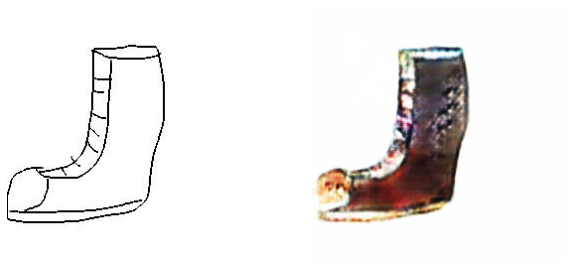

In [51]:
# Optional: for loading saved generator
G_100 = generator().cuda()
# For retrieving the model saved to Google Drive
# TODO: add your notebook path
path = None
if path:
  G_100.load_state_dict(torch.load(path + 'models/G_100.pth'))
else:
  G_100.load_state_dict(torch.load('/content/drive/My Drive/models/G_100.pth'))
# For retreiving the model saved on Colab (you just finished training)

G_100.eval()

# process the sketch
for x_ in custom_loader:
  x_ = x_.cuda()[:,:,:,:img_size]
  y_ = G_100(x_)

# visualize the image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
img_ = process_image(y_[0])
img = process_image(x_[0])
axis[0].imshow(img)
axis[0].axis('off')
axis[1].imshow(img_)
axis[1].axis('off')
plt.show()

# Problem 6.2 calculating receptive field size

Please write down the receptive field size in in this text cell. The receptive field size is calculated with:

 $$r_i = r_{i-1} + ((k_i - 1) * \prod_{j=0}^{i-1}s_j)$$

where $k$ is the kernel size of current layer, $s_j$ is the stride of $j^{th}$ layer, and $r_i$ is the receptive field size of $i^{th}$ layer.

We have $r_0 = 1, s_0 = 1$. The kernel size for all layers in the discriminator is 4, and the stride is 2.

The receptive of C64, C128, C256, C512 is $r_1, r_2, r_3, r_4$ respectively. 

__Please directly replace $?$ with you answer in the expression below.__

$$ Input $$
$$ \downarrow $$
$$ C64 (r_1) (\text{receptive field size} = 1 + 3*2 = 7) $$
$$ \downarrow $$
$$ C128(r_2)(\text{receptive field size}= r_1 + 3*2*2 = 19) $$
$$ \downarrow $$
$$ C256(r_3)(\text{receptive field size}= r_2 + 3*2*2*2 = 43) $$
$$ \downarrow $$
$$ C512(r_4)(\text{receptive field size}= r_3 + 3*2*2*2*2 = 91) $$

# Problem 6.3 style transfer (EECS 504)


## Step 0: Downloading the dataset and backbone network.
For this problem, we will use five images as our artistic style, and the Coco validation set as our content image.

A pretrained SqueezeNet will be applied to extract features.

In [2]:
if os.path.isdir('styles') and os.path.isdir('contents'):
  print('Style images exist')
else:
  print('Downloading images')
  # Download style images
  !wget https://eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
  !unzip style_images.zip && rm style_images.zip

  # Download content images
  !wget http://images.cocodataset.org/zips/val2017.zip
  !unzip -q val2017.zip && rm val2017.zip
  !mkdir contents
  !mv val2017/* ./contents/

# Download the model
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn = cnn.to(device)

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

--2022-10-16 15:03:07--  https://eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
Resolving eecs.umich.edu (eecs.umich.edu)... 141.212.113.199
Connecting to eecs.umich.edu (eecs.umich.edu)|141.212.113.199|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip [following]
--2022-10-16 15:03:08--  https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2587083 (2.5M) [application/zip]
Saving to: ‘style_images.zip’

style_images.zip    100%[===================>]   2.47M  2.43MB/s    in 1.0s    

2022-10-16 15:03:10 (2.43 MB/s) - ‘style_images.zip’ saved [2587083/2587083]

Archive:  style_images.zip
   creating: styles/
  inflatin

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

## STEP 1: Create the image loader and some utility funtions
We provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

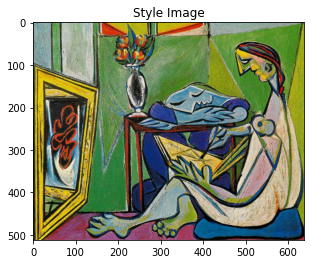

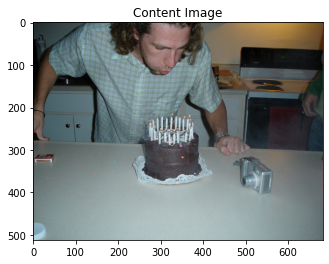

In [3]:
# Dataloader
imsize = 512

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
                transforms.Resize(imsize),
                transforms.ToTensor(),
                transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
                transforms.Lambda(lambda x: x[None]),
                ])
    image = transform(image)
    return image.to(device, torch.float)

# visualizing the content and style images

style_img = image_loader("styles/muse.jpg", imsize)
content_img = image_loader("contents/000000211825.jpg", imsize)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [4]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = []
    in_feat = x
    for layer in cnn._modules.values():
        out_feat = layer(in_feat)
        feats.append(out_feat)
        in_feat = out_feat
    return feats

## Step 2: Implementing content loss
First, we will implement the {\em content loss}. This loss encourages the generated image to match the scene structure of the content image. We will implement this loss as the squared $\ell_2$ distance between two convolutional feature maps. Given a feature map of input image $F^x$ and the feature map of content image $F^{c}$, both of shape $(C, H, W)$, the content loss is calculated as follows:

\begin{equation}
\mathcal{L}_c = \sum_{c,i,j}(F^{c}_{c, i, j} - F^{x}_{c, i, j}) ^ 2. 
\end{equation}

In [5]:
def content_loss(f_x, f_con):
    """
    Compute the gram matrix without loop.
    
    Inputs:
    - f_x: features of the input image with size (1, C, H, W).
    - f_cont: features of the content image with size (1, C, H, W).
    Returns:
    - lc: the content loss
    """

    lc = None

    ###########################################################################
    # TODO: Implement the content loss.                                       #
    # You can check your content loss with some code blocks below             #
    ###########################################################################
   
    lc = F.mse_loss(f_x,f_con)
    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return lc


## Step 3: Implementing style loss
Next, we will implement the {\em style loss}. This loss encourages the texture of the resulting image to match the input style image. We compute a weighted, squared $\ell_2$ distance between Gram matrices for several layers of the network.

The first step is to calculate the Gram matrix. Given a feature map $F$ of size $(C, H, W)$, the Gram matrix $G \in \mathbb{R}^{C \times C}$ computes the sum of products between channels. The entries $k, l$ of the matrix are computed as:
\begin{equation}
G_{k,l} = \sum_{i,j} F_{k,i,j} F_{l,i,j}.
\end{equation}

The second step is to compare the generated image's Gram matrix with that of the input style image. Define the Gram matrix of input image feature map and style image feature map of at the $l^{th}$ layer as $G^{x,l}$ and $G^{s, l}$, and the weight of the layer as $w^l$. Style loss at the $l^{th}$ layer is
\begin{equation}
L_s^l = w^l \sum_{i,j} (G^{x,l}_{i,j} - G^{s, l}_{i,j})^2,
\end{equation}
where $w^l$ is the weight of layer $l$. The total style loss is a sum over all style layers:
\begin{equation}
    \mathcal{L}_s = \sum_l L_s^l.
\end{equation}

In [6]:
def gram_matrix(feat, normalize = True):
    """
    Compute the gram matrix.
    
    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the tram matrix
    """

    gram = None

    ###########################################################################
    # TODO: Implement the gram matrix. You should not use a loop or           #
    # comprehension                                                           #
    ###########################################################################

    B,C,H,W = feat.size()
    tensorShaped = feat.view(B*C,H*W)
    gram = torch.mm(tensorShaped, tensorShaped.t())
    if normalize == True:
      gram = gram.div(B*C*H*W)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return gram

In [7]:
# Test your gram matrix, you should be expecting a difference smaller than 0.001
t1 = torch.arange(8).reshape(1,2,2,2)
result = torch.tensor([[[ 1.7500,  4.7500],[ 4.7500, 15.7500]]])
print(((gram_matrix(t1) - result)**2).sum().item())

0.0


In [8]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:

    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function. The list will contain the features of all layers 
      instead of the layers for calcculating style loss

    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.

    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].

    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - loss: A PyTorch Tensor holding a scalar giving the style loss.
    """

    loss = 0

    ###########################################################################
    # TODO: Implement the style loss                                          #   
    # You can check your style loss with some code blocks below               #
    ###########################################################################

    for index, layer in enumerate(style_layers):
      loss = loss + style_weights[index] * F.mse_loss( gram_matrix(feats[layer]),style_targets[index])

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return loss

## Step 4: Network Training
Test out your style transfer!

In [9]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = image_loader(content_image, image_size)
    feats = get_feature_maps(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = image_loader(style_image, style_size)
    feats = get_feature_maps(style_img, cnn)
    style_targets = []

    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).to(device)
    else:
        img = content_img.clone().to(device)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 1
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = get_feature_maps(img, cnn)
        
        # Compute loss
        c_loss = content_loss(feats[content_layer], content_target) * content_weight
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        loss = c_loss + s_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.figure()
            imshow(img, title='Transferred Image')
            plt.show()
    print('Iteration {}'.format(t))
    plt.figure()
    imshow(img, title='Final transferred Image')


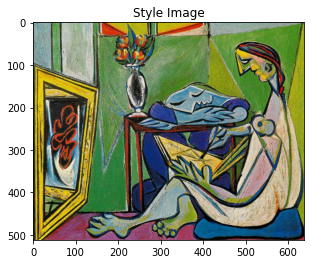

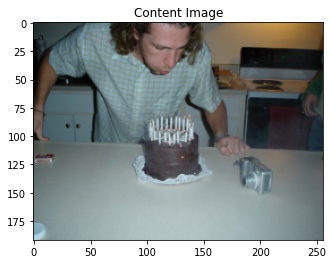

Iteration 0


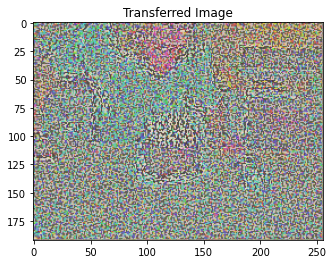

Iteration 100


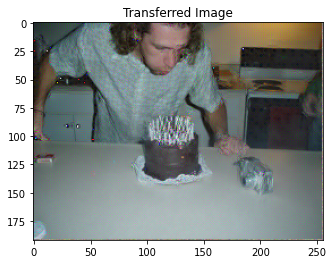

Iteration 199


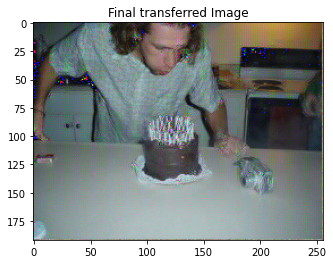

In [10]:
# Check of content loss. Ignore the style image.
params_content_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[0, 0, 0, 0],
    'init_random': True
}

style_transfer(**params_content_check)

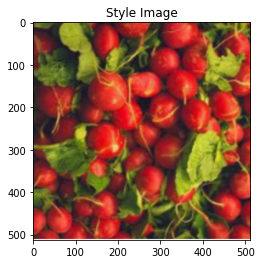

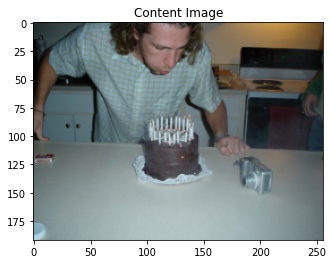

Iteration 0


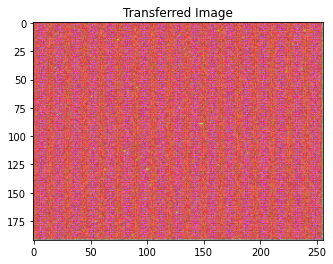

Iteration 100


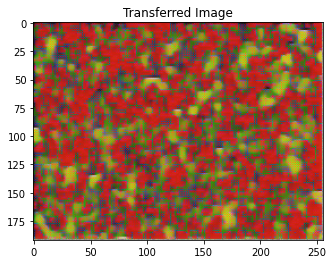

Iteration 199


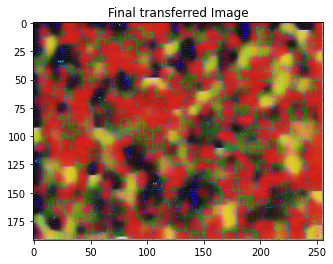

In [11]:
# Check of style loss. You should see the texture of the image. Ignore the content image.
params_style_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/texture.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':0,
    'style_layers':[0, 1],
    'style_weights':[200000, 200000],
    'init_random': True
}

style_transfer(**params_style_check)

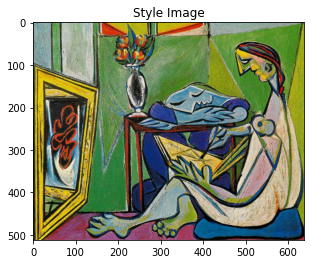

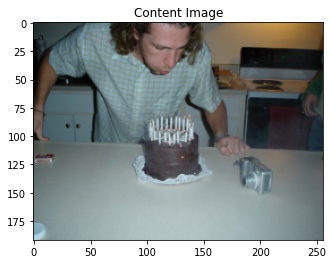

Iteration 0


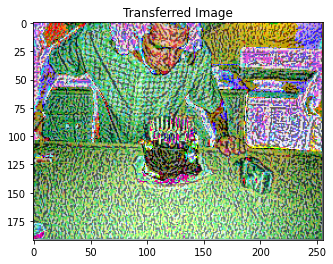

Iteration 100


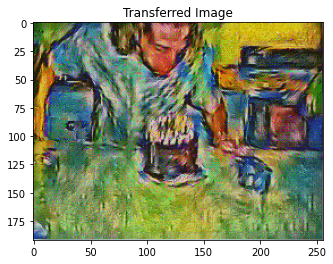

Iteration 199


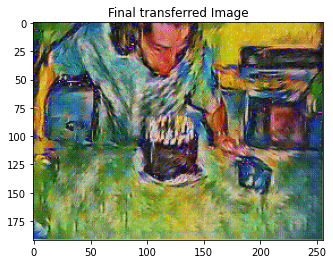

In [27]:
params1 = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':6,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params1)

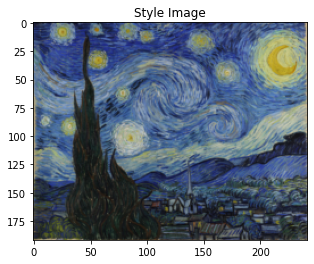

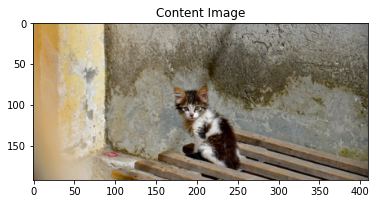

Iteration 0


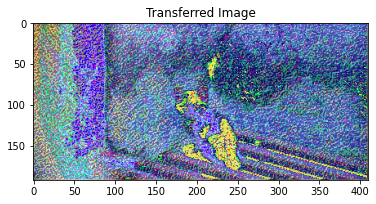

Iteration 100


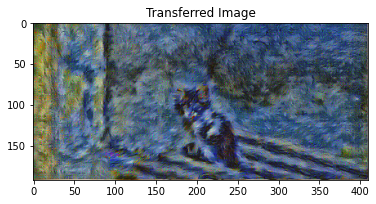

Iteration 199


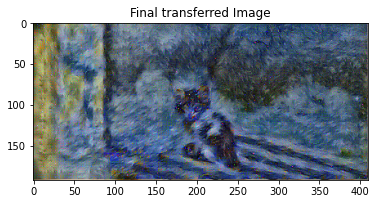

In [26]:
params2 = {
    'content_image':'contents/000000118515.jpg',
    'style_image':'styles/starry_night.jpg',
    'image_size':192,
    'style_size':192,
    'content_layer':6,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params2)

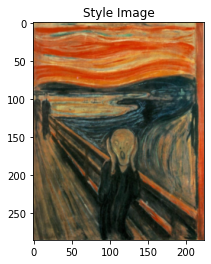

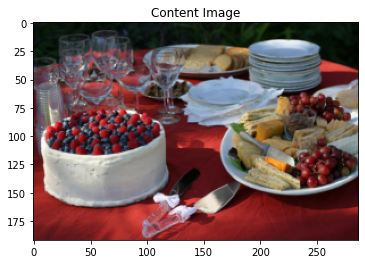

Iteration 0


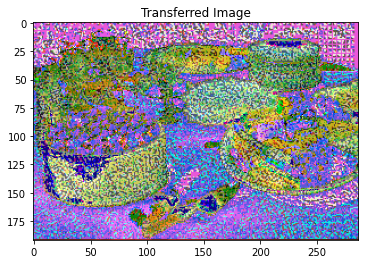

Iteration 100


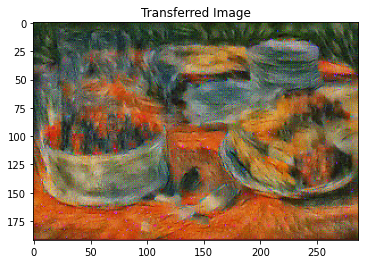

Iteration 199


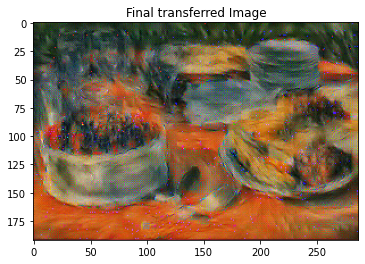

In [25]:
params3 = {
    'content_image':'contents/000000002157.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':6,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params3)

# Feel free ot change the images and get your own style transferred image

### **TODO**: 
Finally, we will try varying the layer used to compute the content loss. Try
different layers l = 0, 1, 2, ..., 12 and report which one provides the best qualitative results.

----------------------------------------------------------------------------

*** It seems that layer = 6 provides a good balance between the content and style. This is slightly subjective but 6 seems ideal given the images above. The default 2,3 layers did not provide a good image and the style enforcement took over completely with not enough restrictions on the content. ***

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [1]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [2]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/My Drive/Colab Notebooks/ps6_javiersc.ipynb' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>